In [85]:
from __future__ import print_function
from __future__ import division
import os
import cPickle as pickle
import json
import subprocess
from IPython.display import display
from IPython.display import Audio
import bisect
from collections import namedtuple
import numpy as np
import pandas as pd
from collections import Counter
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

from matplotlib.ticker import MultipleLocator, \
     FormatStrFormatter, AutoMinorLocator
%matplotlib inline

In [54]:
np.arange(1,20)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

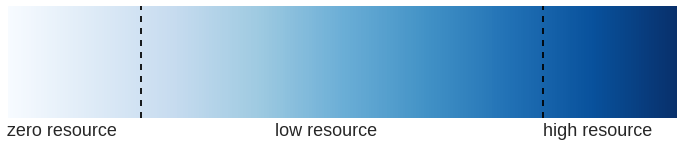

In [55]:
# sns.palplot(sns.color_palette("Blues", 10))

# Set up the matplotlib figure
f, ax1 = plt.subplots(1, 1, figsize=(12, 2), sharex=True)

# Generate some sequential data
x = np.arange(1,1001)
y1 = 2*np.ones(1000)
# sns.barplot(x, y1, palette="Blues_d", edgecolor='0', ax=ax1, width=1)
plt.bar(x, y1, width=1, color=[plt.cm.Blues((1.0*i/len(x))) for i in x], edgecolor='')
# ax1.set_ylabel("Sequential")
ax1.set_xlim(1,1000)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.text(0, -.3, r'zero resource', fontsize=18)
ax1.text(400, -.3, r'low resource', fontsize=18)
ax1.text(800, -.3, r'high resource', fontsize=18)
ax1.axvline(200, linestyle='--', color='k')
ax1.axvline(800, linestyle='--', color='k')
plt.gcf().savefig("resource.png")

# # Center the data to make it diverging
# y2 = y1 - 5
# sns.barplot(x, y2, palette="RdBu_r", ax=ax2)
# ax2.set_ylabel("Diverging")

In [56]:
with open("config.json") as json_data_file:
    config = json.load(json_data_file)

In [57]:
nodes_fname = config["es"]['nodes_fname']
seg_nodes_fname = config["es"]['seg_nodes_fname']
nodes_dict_fname = config["es"]['nodes_dict_fname']

edges_utd_fname = config["es"]['edges_utd_fname']
edges_olap_fname = config["es"]['edges_olap_fname']
edges_all_fname = config["es"]['edges_all_fname']
edges_score_fname = config["es"]['edges_score_fname']

clusters_utd_fname = config['es']['clusters_utd_fname']
clusters_fname = config['es']['clusters_fname']
clusters_stats_fname = config['es']['clusters_stats_fname']

pairs_fname = config['es']['score_pairs_fname']
eval_fname = config['es']['eval_pairs_fname']

feats_fname = config['es']['feats_fname']

# Gold feats
gold_feats_dict_fname = config['es']['gold_feats']
# Pseudo feats
feats_dict_fname = config['es']['feats_dict_fname']

gold_probs_fname = config['es']['mt_probs_gold']
gold_probs_dict_fname = config['es']['mt_probs_dict_gold']

pseudo_probs_fname = config['es']['mt_probs_pseudo']
pseudo_probs_dict_fname = config['es']['mt_probs_dict_pseudo']

train_segment_list_fname = config['es']['mt_train_files']
dev_segment_list_fname = config['es']['mt_dev_files']

gold_corpus_fname = config['es']['mt_corpus_train_gold']
pseudo_corpus_fname = config['es']['mt_corpus_train_pseudo']

mt_gold_pred_dict_fname = config['es']['mt_gold_pred_dict']
mt_pseudo_pred_dict_fname = config['es']['mt_pseudo_pred_dict']

mt_gold_eval_dict_fname = config['es']['mt_gold_eval_dict']
mt_pseudo_eval_dict_fname = config['es']['mt_pseudo_eval_dict']

es_merge_wavs_path = config['es']['es_merge_wavs']
utd_wavs_path = config['es']['utd_wavs']

In [58]:
Align = namedtuple('Align', ['word', 'start', 'end'])
Node = namedtuple('Node', ['file', 'seg', 'start', 'end', 'es', 'es_cnt'])
Eval = namedtuple('Eval', ['n1', 'n2', 'dtw', 'es_sim', 'es_cnt_sim', 'en_j_sim'])

In [69]:
segment_map = pickle.load(open(config['es']['segment_dict_fname'], "rb"))
align_dict = pickle.load(open(config['es']['align_dict_fname'], "rb"))
nodes_dict = pickle.load(open(nodes_dict_fname, "rb"))
pairs_list = pickle.load(open(pairs_fname, "rb"))
eval_dict = pickle.load(open(eval_fname, "rb"))
clusters = pickle.load(open(clusters_fname, "rb"))
clusters_stats = pickle.load(open(clusters_stats_fname, "rb"))
feats_dict = pickle.load(open(feats_dict_fname, "rb"))
gold_feats_dict = pickle.load(open(gold_feats_dict_fname, "rb"))

if os.path.exists(gold_probs_dict_fname):
    gold_probs_dict = pickle.load(open(gold_probs_dict_fname, "rb"))

if os.path.exists(pseudo_probs_dict_fname):
    pseudo_probs_dict = pickle.load(open(pseudo_probs_dict_fname, "rb"))

if os.path.exists(mt_gold_pred_dict_fname):
    mt_gold_pred_dict = pickle.load(open(mt_gold_pred_dict_fname, "rb"))
    
if os.path.exists(mt_pseudo_pred_dict_fname):
    mt_pseudo_pred_dict = pickle.load(open(mt_pseudo_pred_dict_fname, "rb"))

In [73]:
def gen_node_wav(nid, nodes_dict, utd_wavs_path, src_wavs_path, segment_map):
    pair_wavs_path = os.path.join(utd_wavs_path, "wavs")
    nid_fname = os.path.join(pair_wavs_path, "%d.wav" % nid)
    if not os.path.exists(pair_wavs_path):
        os.makedirs(pair_wavs_path)
    if os.path.exists(nid_fname):
        return
    
    segid = nodes_dict[nid].seg
    fid = (segid.split('.')[0]).strip()
    
    merge_wav_start = segment_map[fid][segid] + nodes_dict[nid].start
    merge_wav_end = segment_map[fid][segid] + nodes_dict[nid].end
    
    merge_wav_fname = os.path.join(src_wavs_path, fid+".wav")
    
    start_time = "{0:0.2f}".format(merge_wav_start/100)
    end_time = "={0:0.2f}".format(merge_wav_end/100)
    subprocess.call(["sox", merge_wav_fname, nid_fname, \
                     "trim", start_time, "{0:s}".format(end_time)])
    
    return Audio(nid_fname)
    
    

In [74]:
display(gen_node_wav(1, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))

In [127]:
def display_pair(pid, eval_dict, nodes_dict, align_dict, utd_wavs_path, src_wavs_path, segment_map):
    headers = ["pair id", "nid", "ES transcript", "EN translation"]
    display_pp = PrettyTable(headers, hrules=False)
    
    n1 = eval_dict[pid].n1
    n2 = eval_dict[pid].n2
    
    en_1 = ' '.join([x.word for x in align_dict[nodes_dict[n1].file][nodes_dict[n1].seg]['en']])
    en_2 = ' '.join([x.word for x in align_dict[nodes_dict[n2].file][nodes_dict[n2].seg]['en']])
    
    row_1 = [pid, n1, ' '.join(nodes_dict[n1].es), textwrap.fill(en_1,50)]
    
    row_2 = [pid, n2, ' '.join(nodes_dict[n2].es), textwrap.fill(en_2,50)]
    
    display_pp.add_row(row_1)
    display_pp.add_row(row_2)
    print(display_pp)
    
    display(gen_node_wav(n1, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))
    display(gen_node_wav(n2, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))
    print(display_pp.get_html_string())

    

In [128]:
align_dict['001']['001.001']['en']

[Align(word='MECHITA', start=12, end=50),
 Align(word='WHAT', start=50, end=73),
 Align(word='SENT', start=129, end=169),
 Align(word='IT', start=126, end=129),
 Align(word='TO', start=169, end=176),
 Align(word='WHOM', start=176, end=192),
 Align(word='TO', start=192, end=198),
 Align(word='POCHO', start=198, end=225)]

In [129]:
display_pair(9352, eval_dict, nodes_dict, align_dict, utd_wavs_path, es_merge_wavs_path, segment_map)

+---------+--------+--------------------+---------------------------------------------------+
| pair id |  nid   |   ES transcript    |                   EN translation                  |
+---------+--------+--------------------+---------------------------------------------------+
|   9352  | 168961 |       PORQUE       | NO NO NO BECAUSE BETTER CALL WHEN THE TICKETS ARE |
|         |        |                    |                 ALREADY CONFIRMED                 |
|   9352  | 168962 | PORQUE EL TRAJE DE | BECAUSE THE TOP OF SUIT THE PANTS FIT ME WELL THE |
|         |        |                    |                SUIT WAS THE JACKET                |
+---------+--------+--------------------+---------------------------------------------------+


None

None

<table>
    <tr>
        <th>pair id</th>
        <th>nid</th>
        <th>ES transcript</th>
        <th>EN translation</th>
    </tr>
    <tr>
        <td>9352</td>
        <td>168961</td>
        <td>PORQUE</td>
        <td>NO NO NO BECAUSE BETTER CALL WHEN THE TICKETS ARE<br>ALREADY CONFIRMED</td>
    </tr>
    <tr>
        <td>9352</td>
        <td>168962</td>
        <td>PORQUE EL TRAJE DE</td>
        <td>BECAUSE THE TOP OF SUIT THE PANTS FIT ME WELL THE<br>SUIT WAS THE JACKET</td>
    </tr>
</table>


In [10]:
eval_df = pd.DataFrame(eval_dict, columns=Eval._fields)
clusters_df = pd.DataFrame(clusters_stats)
del clusters_df['avg_purity']
clusters_df['depth'] = clusters_df.apply(lambda row: len(row['words']), axis=1)

In [114]:
(eval_df.sort_values('dtw', ascending=False, inplace=False)).head(10)

,n1,n2,dtw,es_sim,es_cnt_sim,en_j_sim
78704,13189,13190,0.999,0,0,0.000000
9352,100589,100590,0.999,1,1,1.000000
85989,100589,100591,0.999,1,1,0.333333
55260,243685,243686,0.999,1,1,0.166667
12359,31965,31966,0.999,0,0,0.000000
73770,75343,75344,0.999,1,1,1.000000
9665,129547,129548,0.999,0,0,0.500000
120973,2135,2136,0.999,1,1,0.000000
49449,180933,180934,0.999,1,1,1.000000
7509,129539,129540,0.999,0,0,0.000000


In [78]:
print(len(clusters_df), len(clusters_df[clusters_df['depth'] == 0]))

39843 390


In [47]:
clusters_df.head(10)

,most_common,purity,words,depth
0,ver,0.500,"[vamos, ver, vamos, ver]",4
1,mechita,0.375,"[mechita, hablar, mechita, explicar, <backgrou...",8
2,año,1.000,"[año, año]",2
3,diez,0.500,"[diez, días, diez, días]",4
4,cosas,0.500,"[trae, cosas, traen, cosas]",4
5,interpretación,0.400,"[necesita, interpretación, ley, necesita, inte...",5
6,interpretación,1.000,"[interpretación, interpretación]",2
7,mandado,0.400,"[mandado, dónde, mandado, vas, mandar]",5
8,ocho,0.500,"[ocho, lunes, ocho, pues]",4
9,averiguarlo,0.500,"[averiguar, averiguarlo]",2


In [37]:
(clusters_df.sort_values('purity', ascending=False, inplace=False)).head(10)

,most_common,purity,words,depth
654,extrañas,1.0,"[extrañas, extrañas]",2
3897,sonará,1.0,[sonará],1
3893,detalladamente,1.0,[detalladamente],1
7739,difícil,1.0,"[difícil, difícil]",2
6015,cuento,1.0,"[cuento, cuento]",2
6013,entran,1.0,"[entran, entran]",2
7745,accidente,1.0,"[accidente, accidente]",2
3887,palabra,1.0,"[palabra, palabra]",2
1653,año,1.0,"[año, año]",2
6039,mitad,1.0,[mitad],1


In [49]:
Audio('../../../ZRTools/exp/callhome/tmpwav/0008.wav')